# Follow-up intron diversity

## Setup

In [1]:

#QUESTION: DO WE ACTUALLY WANT TO USE THE WHOLE CALLSET OR THE PASSED CALLSET? THE METHOD INHERENTLY REPORTS
#DIVERSITY FOR EVERY ACCESSIBLE POSITION, SO BY USING ONLY THE PASS CALLSETS, WE ARE STILL MAKING A STATEMENT 
#ABOUT FILTER-#FAILING POSITIONS (STATING THAT THERE IS NO DIVERSITY THERE). IT SEEMS TO ME THAT IT THEREFORE 
#MAKES MORE SENSE TO USE ALL SNPS, BUT ALISTAIR'S ORIGINAL NOTEBOOK USES AN OBJECT CALLED callset_pass, SO I 
#ASSUMED THAT IT WAS USING THE PASS SNPS ONLY. 

import sys
import petl as etl
import petlx.bio
import numpy as np
import functools
import allel
import pandas as pd
sys.path.insert(0, '../../agam-report-base/src/python')
from util import *
from ag1k import phase2_ar1
phase2_ar1.init("../../phase2.AR1")
genome = phase2_ar1.genome_agamp4
accessibility = phase2_ar1.accessibility
allele_counts = phase2_ar1.allele_counts
callset = phase2_ar1.callset
callset_pass = phase2_ar1.callset_pass

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
# use seaborn defaults
rcParams = plt.rcParams
rcParams['savefig.jpeg_quality'] = 100
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}

In [3]:
# Having a guess at what Alistair's "get_features" function does
def get_features(chrom):
    return get_geneset_features(phase2_ar1.geneset_agamp44_fn, chrom)

In [4]:
CLS_UPSTREAM = 1
CLS_5UTR = 2
CLS_EXON_FIRST = 3
CLS_INTRON_FIRST = 4
CLS_EXON_MID = 5
CLS_INTRON_LAST = 6
CLS_EXON_LAST = 7
CLS_3UTR = 8
CLS_DOWNSTREAM = 9
CLS_INTRON_MID = 10


def compute_features(chrom):
    log('compute features', chrom)

    # extract features
    ###################
    
    tbl_features = (
        get_features(chrom)
        .convert('start', lambda v: v-1)
        .rename('end', 'stop')
        .unpackdict('attributes', ['Parent', 'ID'])
        .rename('Parent', 'parent')
        .addfield('length', lambda rec: rec.stop-rec.start, index=5)
        .cache()
    )
    
    # obtain genes
    ###############
    
    tbl_genes = tbl_features.eq('type', 'gene')    

    # obtain CDSs
    ##############
    
    def child_first(prv, cur, nxt):
        return (
            (cur.strand == '+' and (prv is None or prv.parent != cur.parent))
            or (cur.strand == '-') and (nxt is None or cur.parent != nxt.parent)
        )

    def child_last(prv, cur, nxt):
        return (
            (cur.strand == '-' and (prv is None or prv.parent != cur.parent))
            or (cur.strand == '+') and (nxt is None or cur.parent != nxt.parent)
        )

    tbl_cdss = (
        tbl_features
        .eq('type', 'CDS')
        .select('parent', lambda v: v.endswith('RA'))
        .addfieldusingcontext('first', child_first)
        .addfieldusingcontext('last', child_last)
    )    

    # obtain introns
    #################
    
    def cds2intron(parent, cdss):
        cdss = list(cdss)
        seqid = cdss[0].seqid
        strand = cdss[0].strand
        type = 'intron'
        for i in range(1, len(cdss)):
            start = cdss[i-1].stop
            stop = cdss[i].start
            yield (seqid, type, start, stop, stop-start, strand, parent)

    tbl_introns = (
        tbl_cdss
        .rowgroupmap(key='parent', mapper=cds2intron, header=['seqid', 'type', 'start', 'stop', 'length', 'strand', 'parent'])
        .addfieldusingcontext('first', child_first)
        .addfieldusingcontext('last', child_last)
    )
    
    # setup outputs
    ################
    
    seq = np.asarray(genome[chrom])
    seq_cls = np.zeros(seq.size, dtype='u1')
    seq_relpos = np.zeros(seq.size, dtype='u4')
    seq_relpos_end = np.zeros(seq.size, dtype='u4')
    seq_flen = np.zeros(seq.size, dtype='u4')
    # This final will specifically be used for comparing mean intron diversity with that found in the
    # dsx intron
    seq_intron_group = np.zeros(seq.size, dtype='u4')

    # build the upstream and downstream classes
    ############################################
    
    prv_gene = None
    for gene in tbl_genes.records():

        if prv_gene is not None and (gene.start - prv_gene.stop) > 1000:

            # midpoint between previous and current genes
            m = (prv_gene.stop + gene.start) // 2

            # deal with previous gene
            if prv_gene.strand == '+':
                prv_cls = CLS_DOWNSTREAM
            else:
                prv_cls = CLS_UPSTREAM
            seq_cls[prv_gene.stop:m] = prv_cls
            seq_relpos[prv_gene.stop:m] = np.arange(m - prv_gene.stop)
            seq_relpos_end[prv_gene.stop:m] = np.arange(m - prv_gene.stop)[::-1]
            seq_flen[prv_gene.stop:m] = m - prv_gene.stop
            
            # deal with current gene
            if gene.strand == '+':
                cls = CLS_UPSTREAM
            else:
                cls = CLS_DOWNSTREAM
            seq_cls[m:gene.start] = cls
            seq_relpos[m:gene.start] = np.arange(gene.start - m)[::-1]
            seq_relpos_end[m:gene.start] = np.arange(gene.start - m)
            seq_flen[m:gene.start] = gene.start - m

        prv_gene = gene

    # build the UTR classes
    ########################
    
    for f in tbl_features.records():

        cls = None
        if f['type'] == 'five_prime_UTR':
            cls = CLS_5UTR
        elif f['type'] == 'three_prime_UTR':
            cls = CLS_3UTR

        if cls:
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start


    # build the exon classes
    #########################
    
    for f in tbl_cdss.records():

        cls = None
        if f.first and not f.last:
            cls = CLS_EXON_FIRST
        elif not f.first and f.last:
            cls = CLS_EXON_LAST
        elif not f.first and not f.last:
            cls = CLS_EXON_MID

        if cls:
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start


    # build the intron classes
    ###########################
    
    counter_value = 0
    for f in tbl_introns.records():

        cls = None
        if f.first and not f.last:
            cls = CLS_INTRON_FIRST
        elif not f.first and f.last:
            cls = CLS_INTRON_LAST
        elif not f.first and not f.last:
            cls = CLS_INTRON_MID

        if cls:
            counter_value += 1
            seq_intron_group[f.start:f.stop] = counter_value
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start

    return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_intron_group


@functools.lru_cache(maxsize=None)
def compute_feature_diversity(chrom, pop='all', filter_acc = True, return_intron_group = False):
    log('compute feature diversity', chrom, pop)
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_intron_group = compute_features(chrom)
    
    # compute mean pairwise difference
    ###################################
    
    seq_mpd = np.zeros(seq_cls.size, dtype='f8')
    filter_pass = phase2_ar1.callset[chrom]['variants/FILTER_PASS']
    ac = allel.AlleleCountsArray(allele_counts[chrom][pop])[filter_pass,:]
    mpd = allel.mean_pairwise_difference(ac)
    pos = callset_pass[chrom]['variants/POS'][:]
    seq_mpd[pos-1] = mpd
    
    # compute watterson's theta
    ############################
    
    seq_wt = np.zeros(seq_cls.size, dtype='f8')
    is_seg = ac.is_segregating().astype('f8')
    n = ac.sum(axis=1).max()
    wt = is_seg / np.sum(1 / np.arange(1, n))
    seq_wt[pos-1] = wt
    
    # filter for accessibility
    ###########################
    
    if filter_acc:
        is_accessible = accessibility[chrom]['is_accessible'][:]
        seq_cls = seq_cls[is_accessible]
        seq_relpos = seq_relpos[is_accessible]
        seq_relpos_end = seq_relpos_end[is_accessible]
        seq_flen = seq_flen[is_accessible]
        seq_mpd = seq_mpd[is_accessible]
        seq_wt = seq_wt[is_accessible]
        seq_intron_group = seq_intron_group[is_accessible]

    # return outputs
    if return_intron_group:
        return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt, seq_intron_group
    else:
        return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt

## Analysis

In [5]:
def plot_feature_diversity(chrom, cls, x_max, y_max=0.04, title=None, min_flen=None):
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt = compute_feature_diversity(chrom)

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_relpos < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=0, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()


In [6]:
def plot_feature_diversity_end(chrom, cls, x_max, y_max=0.04, title=None, min_flen=None):
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt = compute_feature_diversity(chrom)

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_relpos_end < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos_end[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=0, top=y_max)
    ax.set_xlabel('Physical distance from feature end ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    ax.invert_xaxis()
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()


In [7]:
def plot_all_feature_diversity(chrom, x_max=200, y_max=0.04, min_flen=None):
    plot_feature_diversity(chrom, CLS_INTRON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First intron, %s" % chrom)
    plot_feature_diversity(chrom, CLS_INTRON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid intron, %s" % chrom)
    plot_feature_diversity(chrom, CLS_INTRON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last intron, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_EXON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First CDS, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_EXON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid CDS, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_EXON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last CDS, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_3UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="3' UTR, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_5UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="5' UTR, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_UPSTREAM, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Upstream, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_DOWNSTREAM, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Downstream, %s" % chrom)


In [8]:
def plot_all_feature_diversity_end(chrom, x_max=200, y_max=0.04, min_flen=None):
    plot_feature_diversity_end(chrom, CLS_INTRON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First intron, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_INTRON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid intron, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_INTRON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last intron, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_EXON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First CDS, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_EXON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid CDS, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_EXON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last CDS, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_3UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="3' UTR, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_5UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="5' UTR, %s" % chrom)


### Distance from start

In [9]:
#plot_all_feature_diversity('3R')

In [10]:
#plot_all_feature_diversity('3L')

In [11]:
#plot_all_feature_diversity('2R')

In [12]:
#plot_all_feature_diversity('2L')

In [13]:
#plot_all_feature_diversity('X')

### Distance from end

In [14]:
#plot_all_feature_diversity_end('2R')

In [15]:
#plot_all_feature_diversity_end('X')

### Feature length

In [16]:
def plot_feature_diversity_length(chrom, cls, x_min, x_max, x_bin_width, y_max=0.04, title=None):
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt = compute_feature_diversity(chrom)

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_flen < x_max) & (seq_flen > x_min)
    dist = seq_flen[flt]
    values = seq_mpd[flt]

    # plot
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111, facecolor='none')
    sns.despine(ax=ax, offset=5)
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, x_bins=np.arange(x_min, x_max, x_bin_width) + (x_bin_width//2),
                fit_reg=False, ax=ax, scatter_kws=dict(s=15, color='k'))
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=0, top=y_max)
    ax.set_xlabel('Feature length ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_zorder(2)
        
    ax = ax.twinx()
    sns.despine(ax=ax, top=True, left=True, bottom=True, right=False, offset=5)
    ax.hist(dist, bins=np.arange(x_min, x_max, x_bin_width), zorder=-20)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.yaxis.set_label_position('right')
    ax.set_xlim(left=-1, right=x_max)
    ax.set_zorder(1)
    plt.show()


In [17]:
def plot_all_feature_diversity_length(chrom, x_min=1, x_max=1000, x_bin_width=20, y_max=0.04):
    plot_feature_diversity_length(chrom, CLS_INTRON_FIRST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="First intron, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_INTRON_MID, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="Mid intron, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_INTRON_LAST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="Last intron, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_EXON_FIRST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="First CDS, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_EXON_MID, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="Mid CDS, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_EXON_LAST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="Last CDS, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_3UTR, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="3' UTR, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_5UTR, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="5' UTR, %s" % chrom)


In [18]:
#plot_all_feature_diversity_length('3R')

In [19]:
#plot_all_feature_diversity_length('X')

In [20]:
#plot_all_feature_diversity_length('3L')

In [21]:
#plot_all_feature_diversity_length('2R')

In [22]:
#plot_all_feature_diversity_length('2L')

### Distance from start/end (min feature length)

In [23]:
#plot_all_feature_diversity('2R', min_flen=200)

In [24]:
#plot_all_feature_diversity_end('2R', min_flen=200)

In [25]:
#plot_all_feature_diversity('X', min_flen=200)

In [26]:
#plot_all_feature_diversity_end('X', min_flen=200)

## Sandbox

In [27]:
chrom = '2R'
seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt, seq_intron_group = compute_feature_diversity(chrom, return_intron_group = True)
seq_cls.shape



compute feature diversity 2R all
compute features 2R


(39534863,)

In [28]:
seq_cls_nofilter, seq_relpos_nofilter, seq_relpos_end_nofilter, seq_flen_nofilter, seq_mpd_nofilter, seq_wt_nofilter = compute_feature_diversity(chrom, filter_acc = False)
seq_cls_nofilter.shape

compute feature diversity 2R all
compute features 2R


(61545105,)

In [29]:
# Start and end positions of the dsx target region
startpos = 48714638
endpos = 48714659

In [30]:
#Let's see what the data look like in the dsx target region
print(seq_cls_nofilter[range(startpos-1, endpos-1)])
print(seq_relpos_end_nofilter[range(startpos-1, endpos-1)])

# But what we really want is the diversity of the first 200bp of the intron
dsx_target_intron = range(endpos-11, endpos + 189)
print(seq_relpos_end_nofilter[dsx_target_intron])
dsx_acc = accessibility[chrom]['is_accessible'][dsx_target_intron]
dsx_mpd = seq_mpd_nofilter[dsx_target_intron]
dsx_mpd

[7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6]
[81 82 83 84 85 86 87 88 89 90 91  0  1  2  3  4  5  6  7  8  9]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00087566, 0.        , 0.        , 0.00611349, 0.        ,
       0.        , 0.00087566, 0.        , 0.        , 0.00175055,
       0.00785329, 0.00611349, 0.00087566, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00785329, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

/home/eric/Manuscripts/ag1000g-phase2-data-paper/binder/deps/conda/envs/ag1000g-phase2-data-paper/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


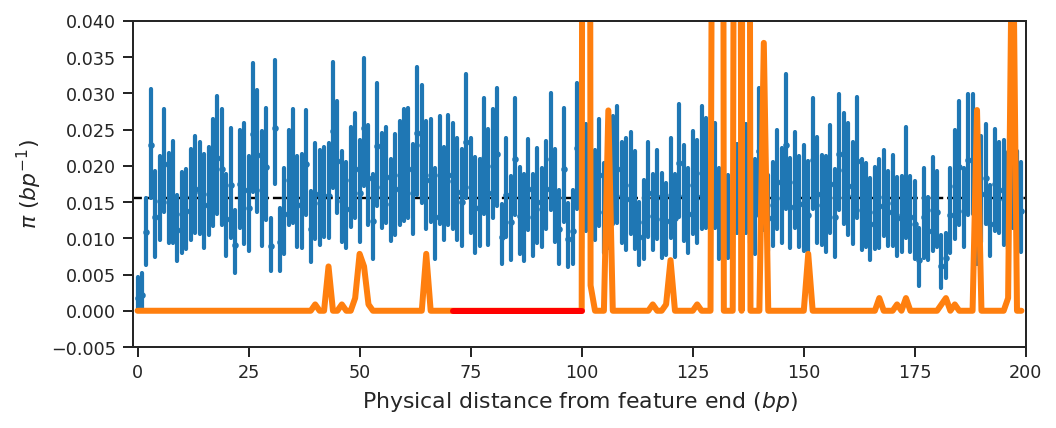

In [31]:
def plot_dsx_against_intron_diversity_end(dsx_data, dsx_acc, title = None):
    
    chrom = '2R'
    cls = CLS_INTRON_LAST
    x_max = 200
    y_min = -0.005
    y_max = 0.04
    min_flen = 200

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_relpos_end < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos_end[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    # since there is only one section of inaccessible bases in dsx, we can vary the line colour thusly
    ax.plot(range(200), dsx_data, lw=3)
    ax.plot(np.array(range(200))[np.invert(dsx_acc)], dsx_data[np.invert(dsx_acc)], lw=3, c = 'red')   
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature end ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    #ax.invert_xaxis()
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

# The blue bars are mean +- 95% conf calculated across 2R. The line shows the observed values for
# the dsx focal intron (organge = accessible, red = inaccessible, bearing in mind that inacessible
# SNPs were not counted, so mpd is always 0 here).
plot_dsx_against_intron_diversity_end(dsx_mpd, dsx_acc)

In [32]:
# Get the positions of interest (from an intron at least 200bp long, but take only the last 100bp of that intron)
flt = ((seq_cls == CLS_INTRON_LAST) | (seq_cls == CLS_INTRON_MID) | (seq_cls == CLS_INTRON_FIRST)) & (seq_flen > 200) & (seq_relpos_end < 100)
# If we want to look at only the "last" intron, use this instead
#flt = (seq_cls == CLS_INTRON_LAST) & (seq_flen > 200) & (seq_relpos_end < 100)
values = seq_mpd[flt]

# We use the intron_group_values to separate the mpd values by the intron to which they belong
seq_intron_group_values = seq_intron_group[flt]
seq_relpos_end_values = seq_relpos_end[flt]
values_grouped = pd.Series(values).groupby(seq_intron_group_values)

In [33]:
# Get the mean mpd values for every intron from which we have at least 20 accessible bases among those 
# last 100 bp. This only uses accessible bases as inaccessible bases were removed when seq_mpd was
# calculated.
intron_group_sizefilter = values_grouped.size() >= 20
intron_group_mpd = values_grouped.mean()[intron_group_sizefilter]
# Now calculate the mean mpd of the last 100 bp dsx intron, removing inaccessible positions. 
dsx_mean_mpd = np.mean(dsx_mpd[:100][dsx_acc[:100]])
# As expected, one of the grouped means is exactly equal to the dsx mean (because dsx is one 
# of the groups):
print(np.sum(intron_group_mpd == dsx_mean_mpd))
# So we remove that value from the group means
intron_group_mpd = intron_group_mpd[np.invert(intron_group_mpd == dsx_mean_mpd)]


1


In [34]:
# What proportion of the distribution is at least as small as the dsx intron?
np.sum(intron_group_mpd <= np.mean(dsx_mean_mpd)) / len(intron_group_mpd)

0.011695906432748537

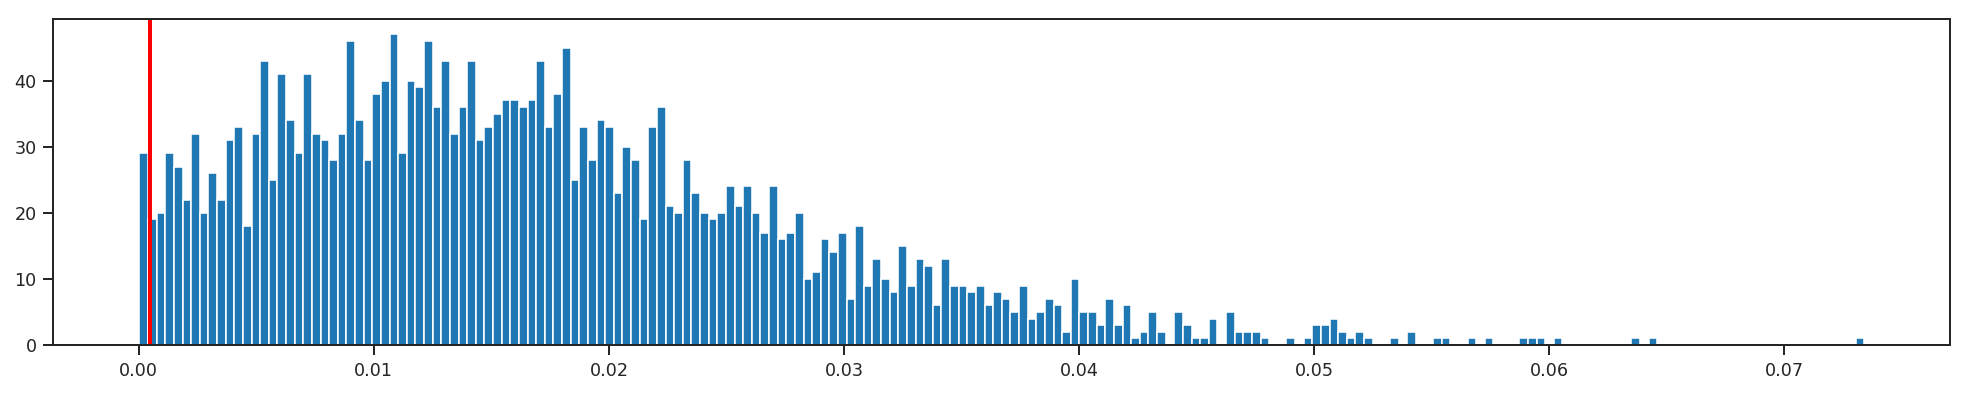

In [35]:
# About 1% of values are at least as small as what we observe in the dsx intron, so the dsx intron
# is at least an outlier. Where does that value plot on a histgram?
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(intron_group_mpd, bins = 200)
ax.axvline(dsx_mean_mpd, color='red', lw = 2)
plt.show()

In [36]:
# Doing a test of statistical significance doesn't really makes sense, I think. I feel that the 
# question "is this intron significantly different from the other introns" would only make sense
# if this intron was an outlier, which it doesn't really appear to be from the distribution above.
# Still, just for completeness, let's see what happens when we do a Mann-Whitney U test.
from scipy.stats import mannwhitneyu
mannwhitneyu([dsx_mean_mpd], intron_group_mpd)
# It's borderline significant

MannwhitneyuResult(statistic=32.0, pvalue=0.04548679258478106)

In [37]:
# I have also tried running this using only the "last" introns for comparisons, and the results
# are pretty much the same 